In [ ]:
import os
import torch
import librosa
import numpy as np

# Define the model class (same as in your training script)
class EmotionModel(torch.nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.fc1 = torch.nn.Linear(15, 64)  # 15 features
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)  # Single output for binary classification
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Load the trained model weights from the .pth file
model = EmotionModel()
model.load_state_dict(torch.load('Models/emotion_model_weights.pth'))  # Path to your saved model weights
model.eval()  # Set the model to evaluation mode

# Function to extract features from a new audio file
def extract_features_from_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean across time
    
    # Extract pitch (fundamental frequency)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch[pitch > 0])  # Mean pitch
    
    # Extract energy (root mean square)
    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)  # Mean energy
    
    # Combine features into a single vector (14 features: 13 MFCCs + pitch + energy)
    features = np.hstack([mfccs_mean, pitch_mean, rmse_mean])
    
    # Print the features for inspection
    print(f"Extracted Features for {audio_path}:")
    print(f"MFCCs: {mfccs_mean}")
    print(f"Pitch: {pitch_mean}")
    print(f"Energy: {rmse_mean}")
    print(f"Full Feature Vector: {features}")
    
    return features

# Function to make predictions based on the extracted features
def predict_emotion(model, audio_path):
    features = extract_features_from_audio(audio_path)
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension (1 sample)
    with torch.no_grad():
        outputs = model(features_tensor)  # Get model prediction
        prediction = (outputs.squeeze() > 0.5).float()  # Convert to binary output (0 for Angry, 1 for Happy)

    return "Angry" if prediction.item() == 0 else "Happy"

# Ensure the 'predictions' directory exists before writing the file
predictions_dir = "predictions"

# Create the directory if it doesn't exist
if not os.path.exists(predictions_dir):
    os.makedirs(predictions_dir)

# Path to the folder containing the new audio files
audio_folder = 'Audio-data/custom_audio/'  # Update this path if needed

# Loop through all .wav files in the folder and predict their emotion
for audio_file in os.listdir(audio_folder):
    if audio_file.endswith(".wav"):  # Only process .wav files
        audio_path = os.path.join(audio_folder, audio_file)

        # Make the prediction
        predicted_emotion = predict_emotion(model, audio_path)

        # Print the prediction to the console
        print(f"The emotion in {audio_file} is predicted as: {predicted_emotion}")

        # Save the prediction result to a text file
        with open(os.path.join(predictions_dir, "prediction_results.txt"), "a") as f:  # 'a' for appending
            f.write(f"{audio_file}: {predicted_emotion}\n")


Extracted Features for Audio-data/custom_audio/Happy German 2.wav:
MFCCs: [-3.70202087e+02  1.26620224e+02  4.52669525e+00  2.44173927e+01
  9.22461128e+00  2.14204063e+01 -1.17449284e+01  2.40594649e+00
 -7.28877020e+00 -1.07671032e+01 -1.76790917e+00 -1.58443046e+00
 -3.20452958e-01]
Pitch: 1301.7117919921875
Energy: 0.03694331645965576
Full Feature Vector: [-3.70202087e+02  1.26620224e+02  4.52669525e+00  2.44173927e+01
  9.22461128e+00  2.14204063e+01 -1.17449284e+01  2.40594649e+00
 -7.28877020e+00 -1.07671032e+01 -1.76790917e+00 -1.58443046e+00
 -3.20452958e-01  1.30171179e+03  3.69433165e-02]
The emotion in Happy German 2.wav is predicted as: Angry
Extracted Features for Audio-data/custom_audio/Happy Elias.wav:
MFCCs: [-422.33133     105.762085     18.217606     11.157942     -4.3764834
   15.257056     -3.3237789     6.342888     -2.0811298    -1.2901683
   -1.2832417     0.52081037    0.71074975]
Pitch: 1290.213623046875
Energy: 0.029435237869620323
Full Feature Vector: [-4.22

In [11]:
import os
import librosa
import numpy as np
import pandas as pd

# Function to extract features from an audio file
def extract_features_from_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=48000)  # Assuming 48kHz sampling rate
    
    # Extract MFCCs (13 MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of MFCCs across time
    
    # Extract pitch (fundamental frequency)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch[pitch > 0])  # Mean pitch
    
    # Extract energy (root mean square)
    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)  # Mean energy
    
    # Return the 14 features
    return np.hstack([mfccs_mean, pitch_mean, rmse_mean])

# Path to your custom audio folder
custom_audio_folder = 'Audio-data/custom_audio'  # Update this path

# List to store features and labels
custom_audio_features = []

# Loop through all .wav files in the folder and extract features
for audio_file in os.listdir(custom_audio_folder):
    if audio_file.endswith(".wav"):  # Only process .wav files
        audio_path = os.path.join(custom_audio_folder, audio_file)
        
        # Extract features for the custom audio file
        features = extract_features_from_audio(audio_path)
        
        # Label as 'Angry' or 'Happy' based on the filename
        # Assuming your custom audio filenames include the emotion (e.g., "happy_example.wav" or "angry_example.wav")
        label = 'Angry' if 'angry' in audio_file.lower() else 'Happy'
        
        # Append the features and label
        custom_audio_features.append(np.hstack([features, label]))

# Create a DataFrame for the custom audio features
custom_audio_df = pd.DataFrame(custom_audio_features, columns=[f"MFCC_{i+1}" for i in range(13)] + ['Pitch', 'Energy', 'Emotion'])

# Save the custom audio features to a CSV file
custom_audio_df.to_csv("custom_audio_features.csv", index=False)
print("Custom audio features saved to 'custom_audio_features.csv'")


Custom audio features saved to 'custom_audio_features.csv'


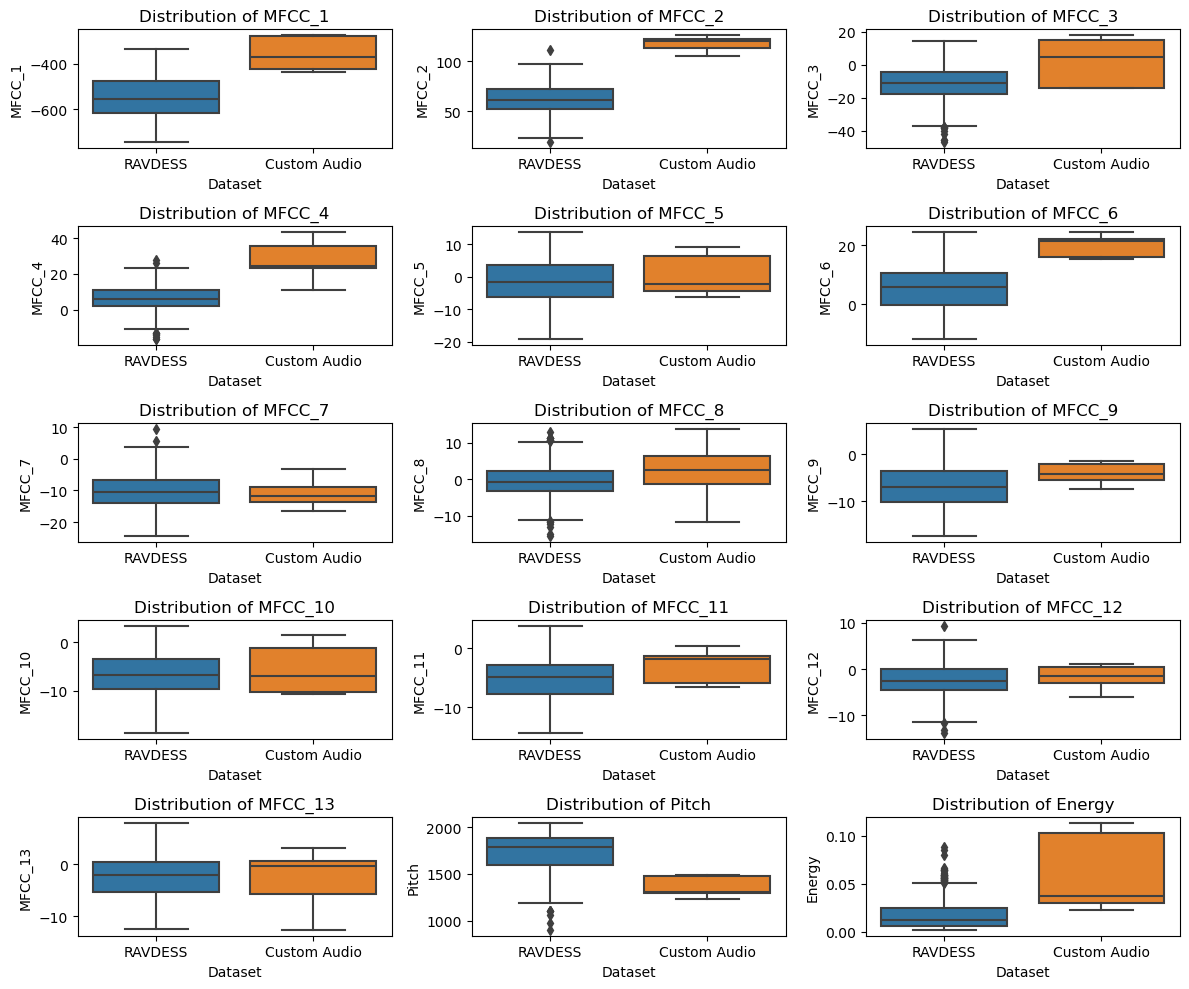

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the RAVDESS dataset (happy-angry.csv)
ravdess_df = pd.read_csv("happy_angry_emotions.csv")

# Load the custom audio dataset
custom_audio_df = pd.read_csv("custom_audio_features.csv")

# Combine the two datasets for comparison
ravdess_df['Dataset'] = 'RAVDESS'
custom_audio_df['Dataset'] = 'Custom Audio'

# Concatenate both DataFrames
combined_df = pd.concat([ravdess_df, custom_audio_df], ignore_index=True)

# Plot the distributions using seaborn
plt.figure(figsize=(12, 10))

# Plot box plots for each feature (13 MFCCs, Pitch, Energy)
for i, feature in enumerate([f"MFCC_{i+1}" for i in range(13)] + ['Pitch', 'Energy']):
    plt.subplot(5, 3, i+1)  # Create a 5x3 grid of subplots
    sns.boxplot(x='Dataset', y=feature, data=combined_df)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


# Test 3

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from features import extract_features_consistent as extract_features
import joblib

# Define EmotionNet3 class
class EmotionNet3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmotionNet3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Setup
input_dim = 38
num_classes = 8
model_path = "Models/emotion_model3.pt"
scaler_path = "Models/feature_scaler.pkl"
audio_folder = "converted_wavs"
predictions_dir = "predictions"

os.makedirs(predictions_dir, exist_ok=True)

# Load model
model = EmotionNet3(input_dim, num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Load scaler
scaler = joblib.load(scaler_path)

# Predict for all .wav files
for audio_file in os.listdir(audio_folder):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(audio_folder, audio_file)

        # Extract and scale features
        features = extract_features(audio_path)
        scaled_features = scaler.transform([features])
        input_tensor = torch.tensor(scaled_features, dtype=torch.float32)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()

        # Save prediction
        with open(os.path.join(predictions_dir, "prediction_results.txt"), "a") as f:
            f.write(f"{audio_file}: {predicted_class}\n")

        print(f"{audio_file}: Predicted emotion class index = {predicted_class}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Happy German 2.wav: Predicted emotion class index = 6
Happy_1748280402.wav: Predicted emotion class index = 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Kids drama sad.wav: Predicted emotion class index = 4
Happy Elias.wav: Predicted emotion class index = 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Dog anger.wav: Predicted emotion class index = 2
Angry elias.wav: Predicted emotion class index = 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Angry_1748280523.wav: Predicted emotion class index = 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Angry English 2.wav: Predicted emotion class index = 6
Happy English 3.wav: Predicted emotion class index = 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilities: {probs.numpy()}")


Probabilities: [[2.3811494e-01 1.5715003e-03 9.6158806e-04 1.1267319e-01 5.2370512e-01
  5.7961186e-04 1.2217867e-01 2.1543153e-04]]
